https://blog.paperspace.com/convolutional-autoencoder/

In [22]:
#  article dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_regular
import seaborn as sns
from torchvision.utils import make_grid
import random

In [27]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

In [28]:
def show_image_grid(images: torch.Tensor, ncol: int):
    image_grid = make_grid(images, ncol)     # Make images into a grid
    image_grid = image_grid.permute(1, 2, 0) # Move channel to the last
    image_grid = image_grid.cpu().numpy()    # Convert into Numpy

    plt.imshow(image_grid)
    plt.xticks([])
    plt.yticks([])
    plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
torch.Size([64, 3, 32, 32])
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2])


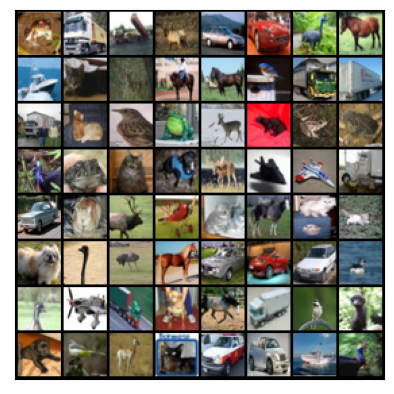

In [20]:
transform = transforms.ToTensor()

#  loading training data
training_set = Datasets.CIFAR10(root='./', download=True,
                              transform=transforms.ToTensor())

#  loading validation data
validation_set = Datasets.CIFAR10(root='./', download=True, train=False,
                                transform=transforms.ToTensor())
dataloader = DataLoader(training_set, batch_size=64, drop_last=True)
images, labels = next(iter(dataloader))

print(images.shape)
print(labels)
show_image_grid(images, ncol=8)



In [23]:
def extract_each_class(dataset):
  """
  This function searches for and returns
  one image per class
  """
  images = []
  ITERATE = True
  i = 0
  j = 0

  while ITERATE:
    for label in tqdm_regular(dataset.targets):
      if label==j:
        images.append(dataset.data[i])
        print(f'class {j} found')
        i+=1
        j+=1
        if j==10:
          ITERATE = False
      else:
        i+=1

  return images
  
  
#  extracting training images
training_images = [x for x in training_set.data]

#  extracting validation images
validation_images = [x for x in validation_set.data]

#  extracting test images for visualization purposes
test_images = extract_each_class(validation_set)

100%|██████████| 10000/10000 [00:00<00:00, 3739905.48it/s]

class 0 found
class 1 found
class 2 found
class 3 found
class 4 found
class 5 found
class 6 found
class 7 found
class 8 found
class 9 found


In [24]:
#  defining dataset class
class CustomCIFAR10(Dataset):
  def __init__(self, data, transforms=None):
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx]

    if self.transforms!=None:
      image = self.transforms(image)
    return image
    
    
#  creating pytorch datasets
training_data = CustomCIFAR10(training_images, transforms=transforms.Compose([transforms.ToTensor(),
                                                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
validation_data = CustomCIFAR10(validation_images, transforms=transforms.Compose([transforms.ToTensor(),
                                                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
test_data = CustomCIFAR10(test_images, transforms=transforms.Compose([transforms.ToTensor(),
                                                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

In [25]:
#  defining encoder
class Encoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
    super().__init__()

    self.net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1), # (32, 32)
        act_fn,
        nn.Conv2d(out_channels, out_channels, 3, padding=1), 
        act_fn,
        nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2), # (16, 16)
        act_fn,
        nn.Conv2d(2*out_channels, 2*out_channels, 3, padding=1),
        act_fn,
        nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2), # (8, 8)
        act_fn,
        nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1),
        act_fn,
        nn.Flatten(),
        nn.Linear(4*out_channels*8*8, latent_dim),
        act_fn
    )

  def forward(self, x):
    x = x.view(-1, 3, 32, 32)
    output = self.net(x)
    return output



In [26]:
#  defining decoder
class Decoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
    super().__init__()

    self.out_channels = out_channels

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, 4*out_channels*8*8),
        act_fn
    )

    self.conv = nn.Sequential(
        nn.ConvTranspose2d(4*out_channels, 4*out_channels, 3, padding=1), # (8, 8)
        act_fn,
        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1, 
                           stride=2, output_padding=1), # (16, 16)
        act_fn,
        nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1, 
                           stride=2, output_padding=1), # (32, 32)
        act_fn,
        nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
    )

  def forward(self, x):
    output = self.linear(x)
    output = output.view(-1, 4*self.out_channels, 8, 8)
    output = self.conv(output)
    return output


In [29]:



#  defining autoencoder
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [30]:
class ConvolutionalAutoencoder():
  def __init__(self, autoencoder):
    self.network = autoencoder
    self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-3)

  def train(self, loss_function, epochs, batch_size, 
            training_set, validation_set, test_set):
    
    #  creating log
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'visualizations': []
    } 

    #  defining weight initialization function
    def init_weights(module):
      if isinstance(module, nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
      elif isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

    #  initializing network weights
    self.network.apply(init_weights)

    #  creating dataloaders
    train_loader = DataLoader(training_set, batch_size)
    val_loader = DataLoader(validation_set, batch_size)
    test_loader = DataLoader(test_set, 10)

    #  setting convnet to training mode
    self.network.train()
    self.network.to(device)

    for epoch in range(epochs):
      print(f'Epoch {epoch+1}/{epochs}')
      train_losses = []

      #------------
      #  TRAINING
      #------------
      print('training...')
      for images in tqdm(train_loader):
        #  zeroing gradients
        self.optimizer.zero_grad()
        #  sending images to device
        images = images.to(device)
        #  reconstructing images
        output = self.network(images)
        #  computing loss
        loss = loss_function(output, images.view(-1, 3, 32, 32))
        #  calculating gradients
        loss.backward()
        #  optimizing weights
        self.optimizer.step()

        #--------------
        # LOGGING
        #--------------
        log_dict['training_loss_per_batch'].append(loss.item())

      #--------------
      # VALIDATION
      #--------------
      print('validating...')
      for val_images in tqdm(val_loader):
        with torch.no_grad():
          #  sending validation images to device
          val_images = val_images.to(device)
          #  reconstructing images
          output = self.network(val_images)
          #  computing validation loss
          val_loss = loss_function(output, val_images.view(-1, 3, 32, 32))

        #--------------
        # LOGGING
        #--------------
        log_dict['validation_loss_per_batch'].append(val_loss.item())


      #--------------
      # VISUALISATION
      #--------------
      print(f'training_loss: {round(loss.item(), 4)} validation_loss: {round(val_loss.item(), 4)}')

      for test_images in test_loader:
        #  sending test images to device
        test_images = test_images.to(device)
        with torch.no_grad():
          #  reconstructing test images
          reconstructed_imgs = self.network(test_images)
        #  sending reconstructed and images to cpu to allow for visualization
        reconstructed_imgs = reconstructed_imgs.cpu()
        test_images = test_images.cpu()

        #  visualisation
        imgs = torch.stack([test_images.view(-1, 3, 32, 32), reconstructed_imgs], 
                          dim=1).flatten(0,1)
        grid = make_grid(imgs, nrow=10, normalize=True, padding=1)
        grid = grid.permute(1, 2, 0)
        plt.figure(dpi=170)
        plt.title('Original/Reconstructed')
        plt.imshow(grid)
        log_dict['visualizations'].append(grid)
        plt.axis('off')
        plt.show()
      
    return log_dict

  def autoencode(self, x):
    return self.network(x)

  def encode(self, x):
    encoder = self.network.encoder
    return encoder(x)
  
  def decode(self, x):
    decoder = self.network.decoder
    return decoder(x)

Epoch 1/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0521 validation_loss: 0.0572


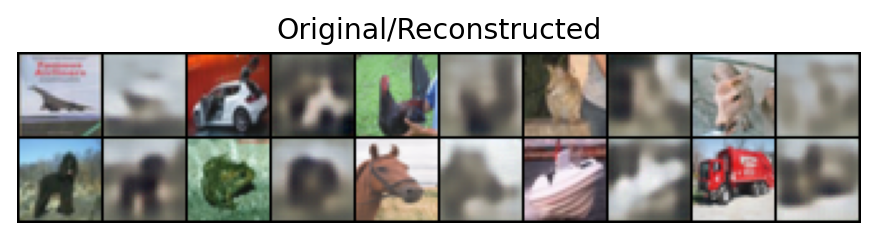

Epoch 2/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0305 validation_loss: 0.0419


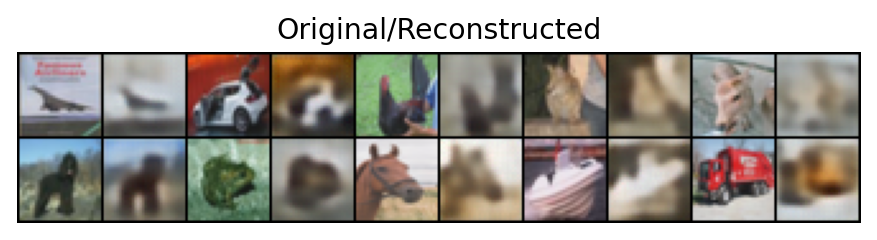

Epoch 3/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.026 validation_loss: 0.0356


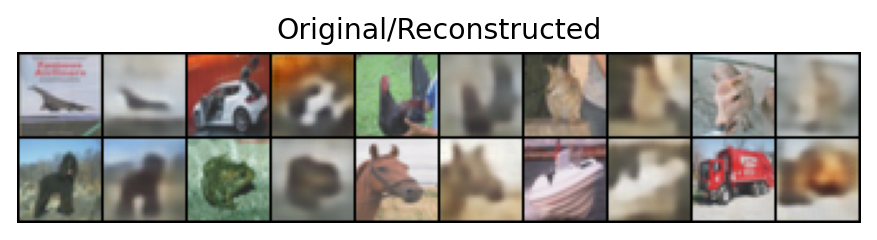

Epoch 4/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0227 validation_loss: 0.0313


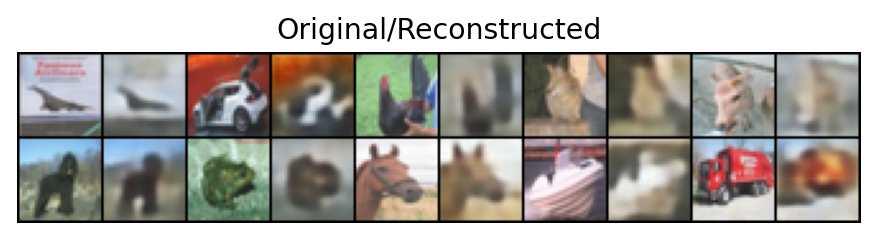

Epoch 5/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0216 validation_loss: 0.0294


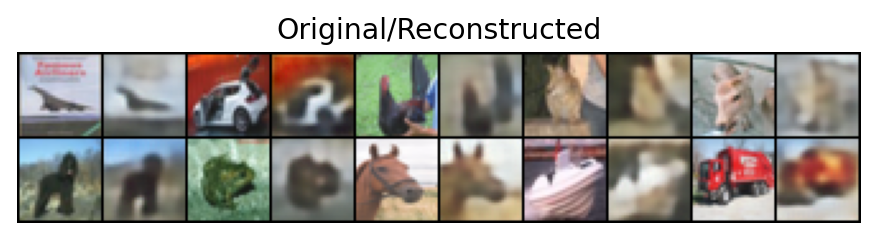

Epoch 6/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0192 validation_loss: 0.0249


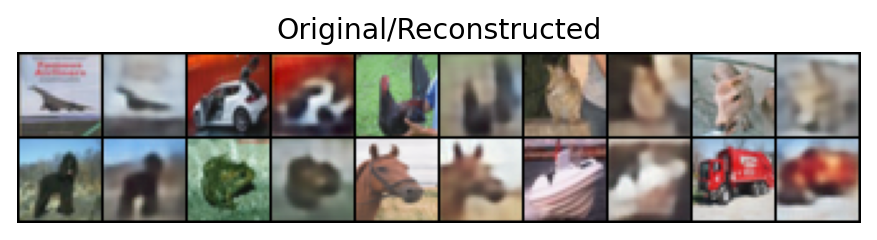

Epoch 7/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0182 validation_loss: 0.0239


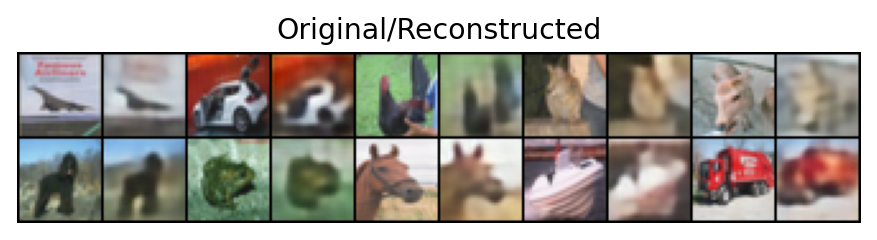

Epoch 8/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0166 validation_loss: 0.0221


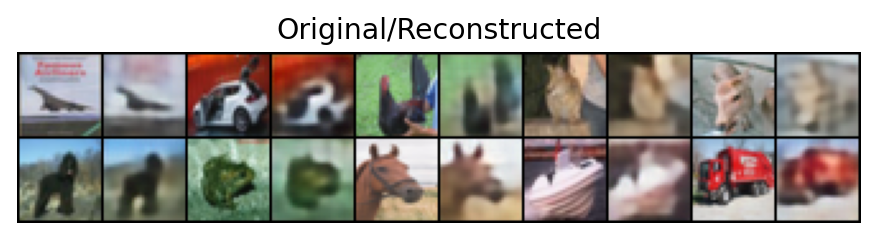

Epoch 9/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0161 validation_loss: 0.0211


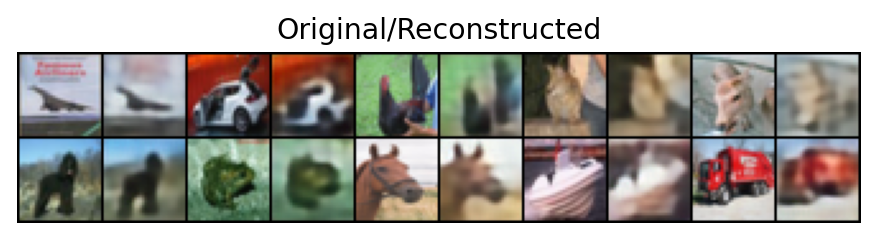

Epoch 10/10
training...


  0%|          | 0/782 [00:00<?, ?it/s]

validating...


  0%|          | 0/157 [00:00<?, ?it/s]

training_loss: 0.0177 validation_loss: 0.0228


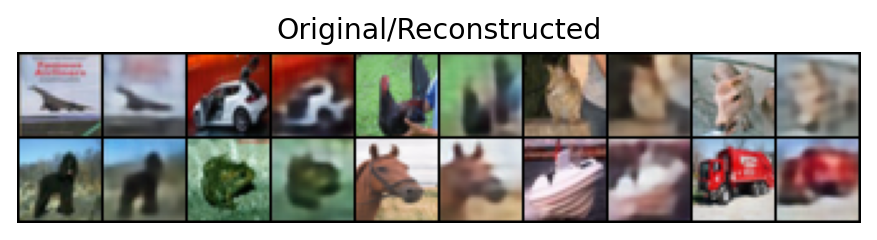

In [31]:
#  training model
model = ConvolutionalAutoencoder(Autoencoder(Encoder(), Decoder()))

log_dict = model.train(nn.MSELoss(), epochs=10, batch_size=64, 
                       training_set=training_data, validation_set=validation_data,
                       test_set=test_data)